#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
#from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: 0.7+0.*x#np.sin(2*np.pi*1*x)*1.+0. #*np.sin(2*np.pi*3*x+.6)

(100, 2)


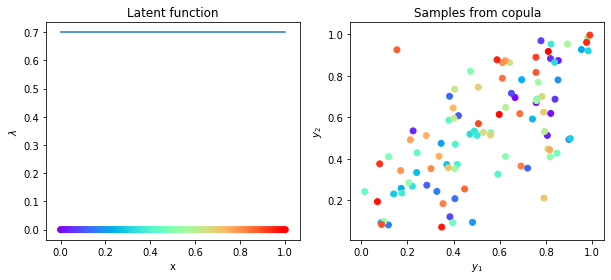

In [3]:
# here we generate some synthetic samples
import matplotlib.cm as cm

NSamp = int(1e2)

X = np.linspace(0.,1.,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

scales = [scale(x) for x in X]
model = GaussianCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [4]:
from torch.distributions import constraints, normal, studentT
from gpytorch.likelihoods.likelihood import Likelihood
from typing import Any
from torch import Tensor

class MixtureCopula(pyro.distributions.torch_distribution.TorchDistribution):
    '''
    This class represents Mixture copula
    '''
    has_rsample = True
    arg_constraints = {"theta": constraints.real, 
                       "mix": constraints.interval(0,1)} #TODO:write simplex constraint for leftmost dimention
    support = constraints.interval(0,1) # [0,1]
    
    def __init__(self, theta, mix, copulas, rotations=None, validate_args=None):
        self.theta = theta
        self.mix = mix
        self.copulas = copulas
        if rotations:
            self.rotations = rotations
        else:
            self.rotations = [None for _ in copulas]
        #TODO Check theta when there will be more than 1 param. Now it is checked by gpytorch
        batch_shape, event_shape = self.theta.shape, torch.Size([2])
        super(MixtureCopula, self).__init__(batch_shape, event_shape, validate_args=validate_args)
    
    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(MixtureCopula, _instance)
        batch_shape = torch.Size(batch_shape)
        if batch_shape == torch.Size([]):
            batch_shape = torch.Size([1])
        theta_shape = batch_shape + torch.Size(self.event_shape[:-1])
        new.theta = self.theta.expand(theta_shape) 
        new.mix = self.mix.expand(theta_shape)
        super(MixtureCopula, new).__init__(batch_shape,
                                                self.event_shape,
                                                validate_args=False)
        new.copulas = self.copulas
        new.rotations = self.rotations
        new._validate_args = self._validate_args
        return new
    
    def rsample(self, sample_shape=torch.Size([])):
        shape = self._extended_shape(sample_shape) # now it is copulas x sample_size x 2 (event)
        
#         if sample_shape == torch.Size([]):   # not sure what to do with 1 sample
#             shape = torch.Size([1]) + shape
    
        samples = torch.zeros(size=shape[1:])
        if self.theta.is_cuda:
            get_cuda_device = self.theta.get_device()
            samples = samples.cuda(device=get_cuda_device)
        num_thetas = self.theta.shape[0]
        
        assert num_thetas==len(copulas)
        assert num_thetas==self.mix.shape[0]
        
        onehot = torch.distributions.one_hot_categorical.OneHotCategorical(
            probs=torch.einsum('i...->...i', self.mix)).sample()
        onehot = torch.einsum('...i->i...', onehot)
        onehot = onehot.type(torch.ByteTensor)
        for i,c in enumerate(copulas):
            samples[onehot[i],...] = c(self.theta[i,onehot[i]], rotation=self.rotations[i]).sample()
        
        return samples

    def log_prob(self, value):

#         if self._validate_args:
#             self._validate_sample(value)
        assert value.shape[-1] == 2 #check that the samples are pairs of variables
        log_prob = torch.zeros_like(self.theta[0]) # by default
        
        assert self.theta.shape[0]==len(copulas)
        assert self.mix.shape[0]==len(copulas)
        assert torch.allclose(self.mix[0],1.-self.mix[1],atol=0.01)
        
        for i, c in enumerate(self.copulas):
            log_prob += c(self.theta[i], rotation=self.rotations[i]).log_prob(value).exp()*self.mix[i]
            #TODO is it possible to vectorize this part?
        log_prob = log_prob.log()
        
        return log_prob

In [5]:
#here we specify a 'true' latent function lambda
theta1 = lambda x: np.cos(2*np.pi*1*x)*.1+9. #*np.sin(2*np.pi*3*x+.6)
theta2 = lambda x: np.sin(2*np.pi*1*x)*.1+8. #*np.sin(2*np.pi*3*x+.6)
con = lambda x: np.cos(2*np.pi*1*x)*0.2+0.5 #*np.sin(2*np.pi*3*x+.6)

In [6]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float()#.cuda(device=0)
train_y = torch.tensor(Y).float()#.cuda(device=0)

In [7]:
# define the model (optionally on GPU)
grid_size = 128
#model = GPInferenceModel(train_x, GaussianCopula_Likelihood())#.cuda(device=0)
#likelihood = GaussianCopula_Likelihood()#.cuda(device=0)
model = KISS_GPInferenceModel(GaussianCopula_Likelihood(), prior_rbf_length=0.3, grid_size=grid_size)#.cuda(device=0)

In [8]:
params = {}
for n,p in model.named_parameters():
    #print(n)
    #print(p)
    params[n]=p


In [9]:
# train the model

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.covar_module.raw_outputscale},
    {'params': model.variational_strategy.variational_distribution.variational_mean, 'lr': .01},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .0001} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
#mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means = [], [], []

def train(num_iter=2000):
    model.train()

    p = 0.
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)  
        #log_lik, kl_div, log_prior = mllv(output, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().numpy().copy())
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy().copy())
        if not (i + 1) % iter_print:
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), mean_p/np.abs(loss.detach().numpy()), np.mean(means[-1]), np.mean(np.abs(1-means[-100]/means[-1]))
            ))
            #print("{:.3}, {:.3}, {:.3}".format(log_lik, kl_div, log_prior))

            #print(np.std(losses[-100:]))
            if (0 < mean_p/np.abs(loss.detach().numpy()) < 0.01):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step

        loss.backward()
        optimizer.step()
        
%time train()

Basic lr for most of parameters: 0.001
Iter 100/2000 - Loss: 0.0177   lengthscale: 0.302, dLoss: 0.0, mean f: 0.222, dmean: 1.0
Iter 200/2000 - Loss: -0.0713   lengthscale: 0.305, dLoss: 1.75, mean f: 0.378, dmean: 0.424
Iter 300/2000 - Loss: -0.047   lengthscale: 0.308, dLoss: 0.838, mean f: 0.5, dmean: 0.25
Iter 400/2000 - Loss: -0.132   lengthscale: 0.31, dLoss: 0.203, mean f: 0.615, dmean: 0.189
Iter 500/2000 - Loss: -0.122   lengthscale: 0.313, dLoss: 0.164, mean f: 0.695, dmean: 0.109
Iter 600/2000 - Loss: -0.179   lengthscale: 0.315, dLoss: 0.0853, mean f: 0.771, dmean: 0.0963
Iter 700/2000 - Loss: -0.219   lengthscale: 0.318, dLoss: 0.0541, mean f: 0.837, dmean: 0.0768
Iter 800/2000 - Loss: -0.226   lengthscale: 0.319, dLoss: 0.0453, mean f: 0.895, dmean: 0.064
Iter 900/2000 - Loss: -0.224   lengthscale: 0.321, dLoss: 0.0221, mean f: 0.937, dmean: 0.0457
Iter 1000/2000 - Loss: -0.246   lengthscale: 0.322, dLoss: 0.028, mean f: 0.975, dmean: 0.0401
Iter 1100/2000 - Loss: -0.244 

In [10]:
losses=np.array(losses)
np.max(losses)

1.5015315

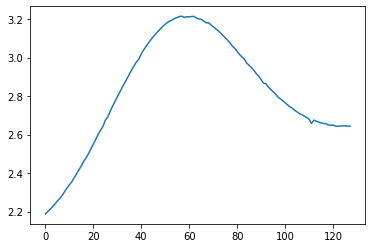

In [11]:
plt.plot(np.exp(means[-1]))
losses[losses!=losses] = 0

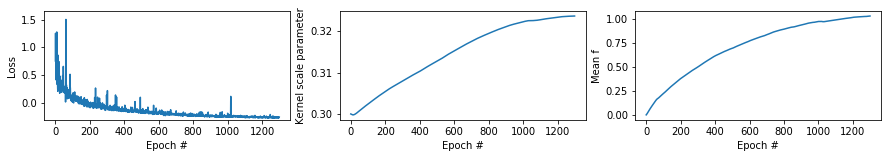

In [12]:
# prot loss function and kernel length
fig, (lossp, kern, mean) = plt.subplots(1,3,figsize=(15,2))
lossp.plot(losses)
lossp.set_xlabel("Epoch #")
lossp.set_ylabel("Loss")
lossp.set_ylim(np.min(losses)*1.1,np.max(losses)*1.1)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [13]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float()#.cuda(device=0)

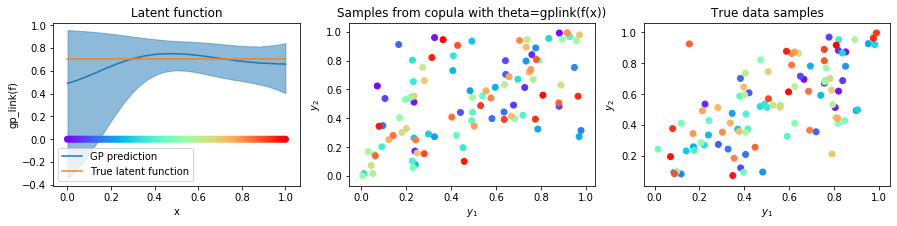

In [14]:
# visualize the result
fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
 
samples = output.rsample(torch.Size([2048]))
F_mean = gplink(samples).mean(0).detach().cpu().numpy()
#F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 1
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula with theta=gplink(f(x))')
true.set_title('True data samples')
# samp.legend()

fig.show()